# DataCamp Code-along - Dataset creation

You can run this notebook on a free-tier Google Colab (T4 GPU).

## 1. Introduction

High-quality data is fundamental to produce a good model. The higher the quality, the better the model. In this notebook, we will create a dataset for fine-tuning LLMs.

![](https://i.imgur.com/IDNhAWH.png)

There are different types of datasets we can use to fine-tune LLMs:

1. **Instruction datasets**: inputs are instructions (e.g., questions) and outputs correspond to the expected responses (e.g., answers). *Example: Open-Orca.*
2. **Raw completion**: this is a continuation of the pre-training objective (next token prediction). In this case, the trained model is not designed to be used as an assistant. *Example: MADLAD-400.*
3. **Preference datasets**: these datasets are used with reinforcement learning to rank candidate responses. They can provide multiple answers to the same instruction, and help the model to select the best response. *Example: ultrafeedback_binarized.*
4. **Others**: a fill-in-the-middle objective is very popular with code completion models (e.g., Codex from GitHub Copilot). Other datasets can be designed for classification, where the outputs correspond to the labels we want to predict (the model requires an additional classfication head in this case).

In practice, supervised fine-tuning only leverages the first type of dataset. We can either **create our own** instruction dataset or **modify an existing one** to filter, improve, or enrich it.

## 2. Load and analyze the dataset

In this notebook, we will filter the excellent [Open-Platypus dataset](https://huggingface.co/datasets/garage-bAInd/Open-Platypus). It's already a collection of different datasets:

| Dataset Name                                                 | License Type |
|--------------------------------------------------------------|--------------|
| [PRM800K](https://github.com/openai/prm800k)                 | MIT          |
| [ScienceQA](https://github.com/lupantech/ScienceQA) | [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)    |
| [SciBench](https://github.com/mandyyyyii/scibench)    | MIT      |
| [ReClor](https://whyu.me/reclor/)                            | Non-commercial      |
| [TheoremQA](https://huggingface.co/datasets/wenhu/TheoremQA) | MIT      |
| [`nuprl/leetcode-solutions-python-testgen-gpt4`](https://huggingface.co/datasets/nuprl/leetcode-solutions-python-testgen-gpt4/viewer/nuprl--leetcode-solutions-python-testgen-gpt4/train?p=1) | None listed |
| [`jondurbin/airoboros-gpt4-1.4.1`](https://huggingface.co/datasets/jondurbin/airoboros-gpt4-1.4.1) | other |
| [`TigerResearch/tigerbot-kaggle-leetcodesolutions-en-2k`](https://huggingface.co/datasets/TigerResearch/tigerbot-kaggle-leetcodesolutions-en-2k/viewer/TigerResearch--tigerbot-kaggle-leetcodesolutions-en-2k/train?p=2) | apache-2.0 |
| [openbookQA](https://huggingface.co/datasets/openbookqa/viewer/additional/train?row=35) | apache-2.0      |
| [ARB](https://arb.duckai.org)                                | MIT      |
| [`timdettmers/openassistant-guanaco`](https://huggingface.co/datasets/timdettmers/openassistant-guanaco)                                | apache-2.0      |

In [1]:
# Install libraries
!pip install -q datasets transformers sentence_transformers faiss-gpu

You can find your token at this address: https://huggingface.co/settings/tokens and copy paste it in the "Secrets" tab in Google Colab (name: "huggingface").

In [2]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("garage-bAInd/Open-Platypus")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 24926
    })
})

In [3]:
# Read as pandas DataFrame
dataset['train'].to_pandas()

,input,output,instruction,data_source
0,,To find the probability of the spinner landing...,A board game spinner is divided into three par...,MATH/PRM-800K
1,,"I need to choose 6 people out of 14, and the o...",My school's math club has 6 boys and 8 girls. ...,MATH/PRM-800K
2,,First we count the number of all 4-letter word...,How many 4-letter words with at least one cons...,MATH/PRM-800K
3,,She can do this if and only if at least one of...,Melinda will roll two standard six-sided dice ...,MATH/PRM-800K
4,,Think of the problem as a sequence of H's and ...,"Let $p$ be the probability that, in the proces...",MATH/PRM-800K
...,...,...,...,...
24921,,There are several formulas that generate all p...,Can we find a formula to generate all prime nu...,guanaco
24922,,"Sure, here are some of the best universities:\...",What are some of the best university's for stu...,guanaco
24923,,[Enter stage left]\n\nFirst Citizen: Good morr...,Write me a SPL (Shakespeare Programming Langua...,guanaco
24924,,That's a very thoughtful idea! Here are some s...,Hi. I want to make an embossed picture for my ...,guanaco


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


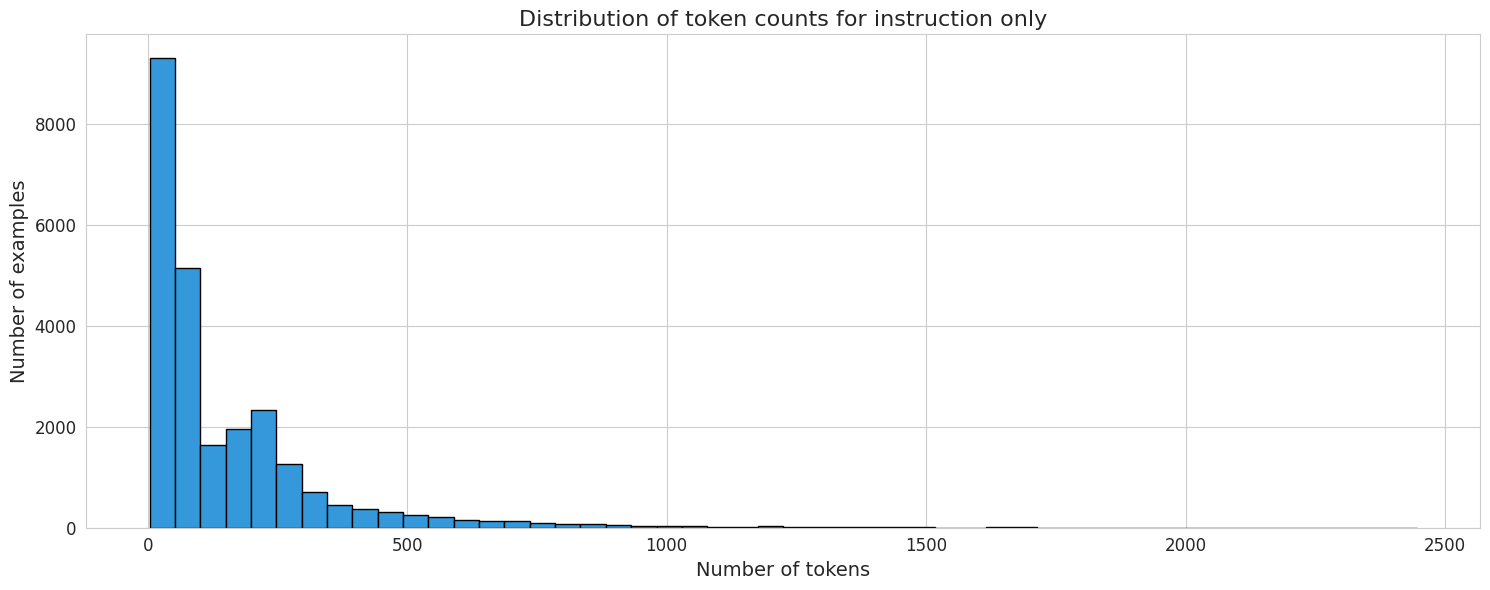

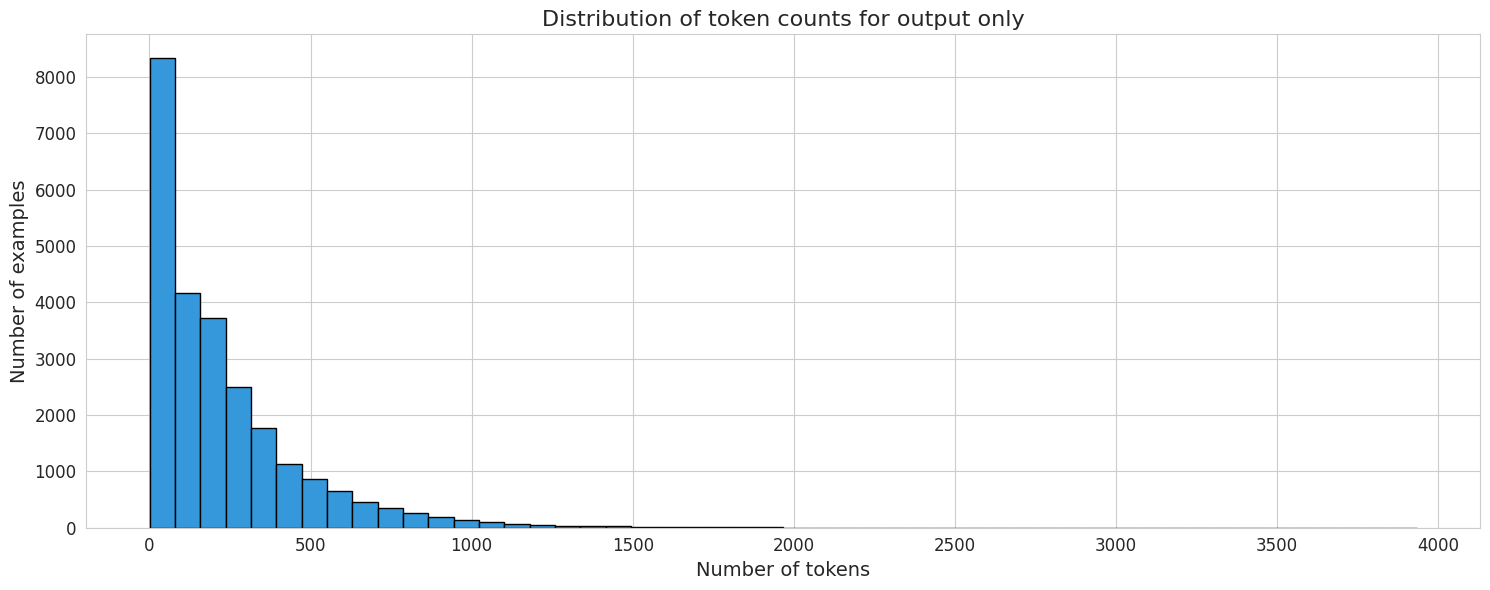

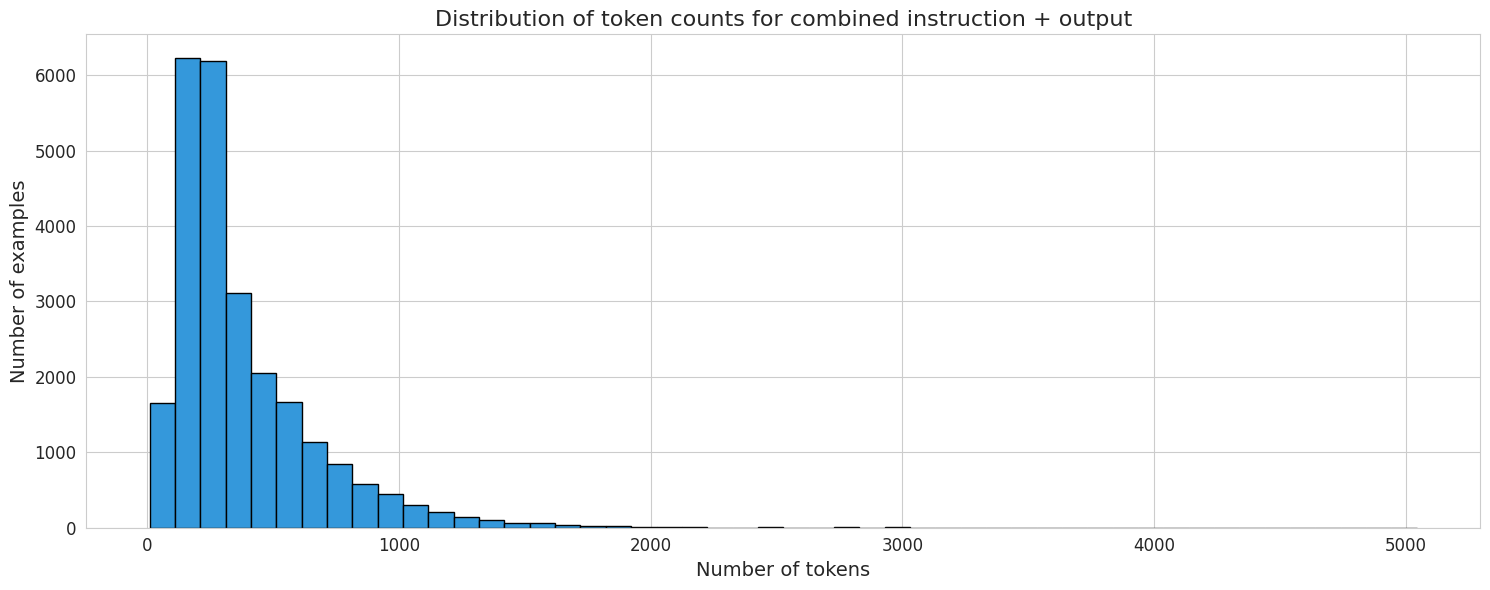

In [4]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")

# 2. Tokenize each row and count the number of tokens
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

## 3. Filter out rows with more than 2048 tokens

We can remove samples with more than 2048 tokens (max context size of Llama 2 by default = 4096).

Number of valid rows: 24895
Removing 31 rows...


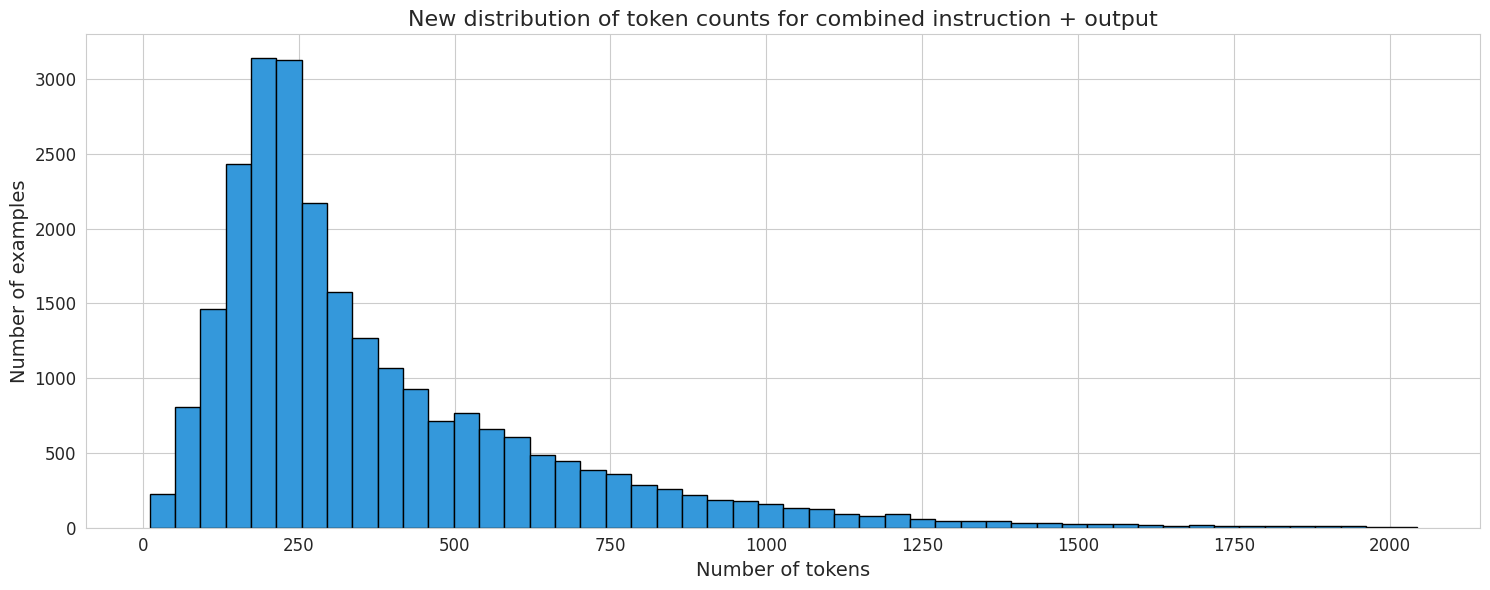

In [5]:
# Filter out rows with more than 2048 tokens
valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 2048]
print(f"Number of valid rows: {len(valid_indices)}")
print(f"Removing {len(dataset['train']) - len(valid_indices)} rows...")

# Extract valid rows based on indices
dataset['train'] = dataset['train'].select(valid_indices)

# Get token counts for valid rows
token_counts = [combined_token_counts[i] for i in valid_indices]

plot_distribution(token_counts, "New distribution of token counts for combined instruction + output")

## 4. Near-deduplication using embeddings

How to choose the embedding model? Check the [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard). In this example, we're not using the best embedding model because it would take too long.

![](https://i.imgur.com/Fbx1Ivz.png)

In [6]:
from sentence_transformers import SentenceTransformer
import faiss
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
    sentence_model = SentenceTransformer(model)
    outputs = [example["output"] for example in dataset['train']]

    print("Converting text to embeddings...")
    embeddings = sentence_model.encode(outputs, show_progress_bar=True)
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    index.add(normalized_embeddings)

    print("Filtering out near-duplicates...")
    D, I = index.search(normalized_embeddings, k=2)
    to_keep = []

    for i in tqdm(range(len(embeddings)), desc="Filtering"):
        # If the second closest vector (D[i, 1]) has cosine similarity above the threshold
        if D[i, 1] >= threshold:
            # Check if either the current item or its nearest neighbor is already in the to_keep list
            nearest_neighbor = I[i, 1]
            if i not in to_keep and nearest_neighbor not in to_keep:
                # If not, add the current item to the list
                to_keep.append(i)
        else:
            # If the similarity is below the threshold, always keep the current item
            to_keep.append(i)

    dataset = dataset['train'].select(to_keep)
    return DatasetDict({"train": dataset})

deduped_dataset = deduplicate_dataset(dataset, "thenlper/gte-large", 0.95)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Converting text to embeddings...


Batches:   0%|          | 0/778 [00:00<?, ?it/s]

Filtering out near-duplicates...


Filtering:   0%|          | 0/24895 [00:00<?, ?it/s]

In [7]:
print(f"Number of samples in the original dataset: {len(dataset['train'])}")
print(f"Number of samples in the deduped dataset: {len(deduped_dataset['train'])}")
print(f"Number of samples that were removed: {len(dataset['train']) - len(deduped_dataset['train'])}")

Number of samples in the original dataset: 24895
Number of samples in the deduped dataset: 18161
Number of samples that were removed: 6734


## 5. Top-k sampling

Only keep the top k samples with the most tokens.

In [8]:
# Get the top k rows with the most tokens
def get_top_k_rows(dataset, token_counts, k):
    # Sort by descending token count and get top k indices
    sorted_indices = sorted(range(len(token_counts)), key=lambda i: token_counts[i], reverse=True)
    top_k_indices = sorted_indices[:k]

    # Extract top k rows
    top_k_data = {
        "instruction": [dataset['train'][i]["instruction"] for i in top_k_indices],
        "output": [dataset['train'][i]["output"] for i in top_k_indices]
    }

    return Dataset.from_dict(top_k_data)

# Get token counts
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in deduped_dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in deduped_dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

k = 1000  # You can adjust this value as needed
top_k_dataset = get_top_k_rows(deduped_dataset, combined_token_counts, k)

# Save these rows in a Dataset object with a 'train' split
dataset = DatasetDict({"train": top_k_dataset})

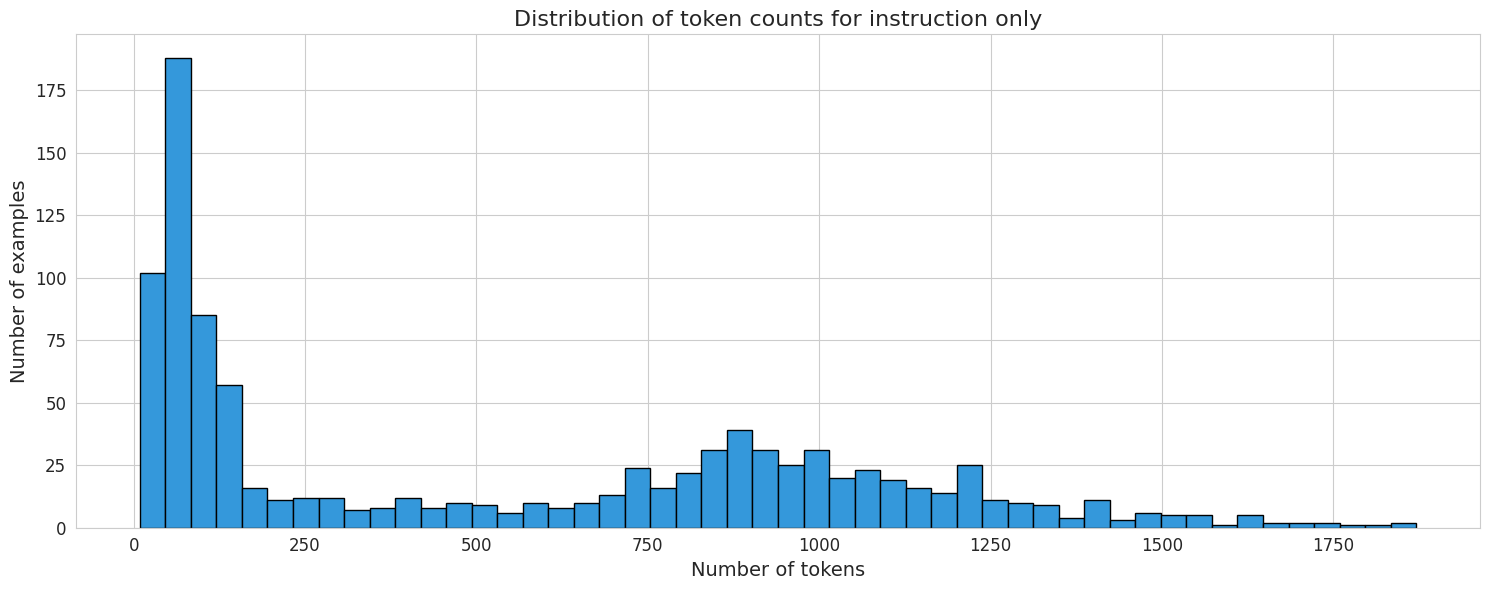

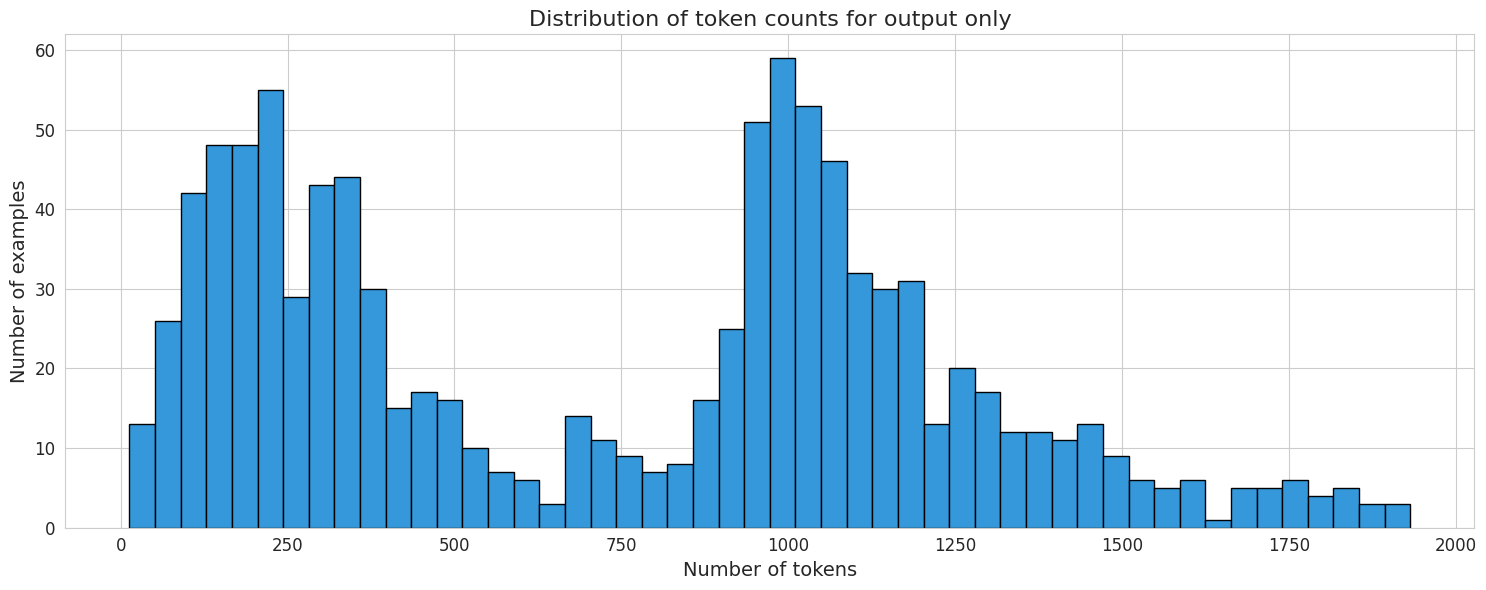

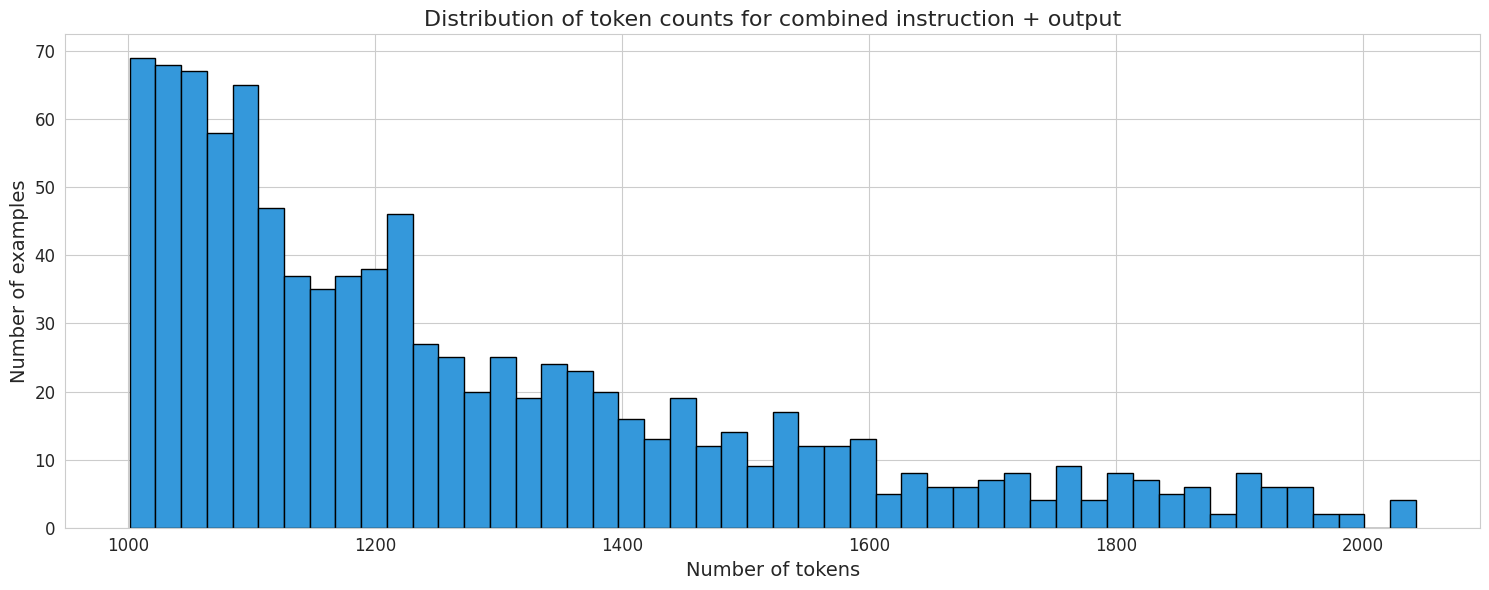

In [9]:
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

In [10]:
# Read as pandas DataFrame
dataset['train'].to_pandas()

,instruction,output
0,Let's come up with a rich and complex alien wo...,Planet Name: Xylothar\n\nXylothar is a diverse...
1,"Let\n$$p(x,y) = a_0 + a_1x + a_2y + a_3x^2 + a...","Observe that \begin{align*}\np(0,0) &= a_0 = ..."
2,"Given the code below, refactor it, add comment...",Here is the refactored and commented version:\...
3,Find the area of the region described by $x \g...,"Let $n = \lfloor x \rfloor,$ and let $\{x\} = ..."
4,Let $P$ be the plane passing through the origi...,Let $\mathbf{v} = \begin{pmatrix} x \\ y \\ z ...
...,...,...
995,Hello. My name is Mike. I have a message left ...,"Hello Mike, it's nice to meet you. As an AI la..."
996,"Given a prime $p$ and an integer $a$, we say t...","To find the primitive roots $\pmod 7$, I need ..."
997,Let $f$ be defined by \[f(x) = \left\{\n\begi...,The number $f^{-1}(-3)$ is the value of $x$ su...
998,"BEGININPUT\nBEGINCONTEXT\ndate: August 5, 2021...",Dr. Eleanor Thompson's study found that partic...


## 6. Chat templates

We need to define a **chat template**, which formats the instructions and responses in a way that is suitable for the model. Here's an example of raw instructions and responses from a [Hugging Face blog post](https://huggingface.co/blog/chat-templates):

```
[
    {"role": "user", "content": "Hi there!"},
    {"role": "assistant", "content": "Nice to meet you!"}
]
```

There are different ways to format it. The most straightforward one would be:

```
User: Hey there!
Assistant: Nice to meet you!
```

In the case of Llama 2, the authors used the following template for the **chat models**:

```
<s>[INST] <<SYS>>
System prompt
<</SYS>>

User prompt [/INST] Model answer </s>
```

Currently, the most popular and standardized chat template is ChatML from OpenAI, which looks like this:

```
<|im_start|>user
Hey there!<|im_end|>
<|im_start|>assistant
Nice to meet you!<|im_end|>
```

The impact of chat templates on the performance of the model is unclear. In most cases, we fine-tune base models that have not been trained with a particular template, which is also why there's no clear standard. However, they are important as they can cause many issues and limit the compatibility of your models.

In [11]:
def chat_template(example):
    example["instruction"] = f"### Instruction:\n{example['instruction']}\n\n### Response:\n"
    return example

dataset = dataset.map(chat_template)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [12]:
dataset['train'].to_pandas()

,instruction,output
0,### Instruction:\nLet's come up with a rich an...,Planet Name: Xylothar\n\nXylothar is a diverse...
1,"### Instruction:\nLet\n$$p(x,y) = a_0 + a_1x +...","Observe that \begin{align*}\np(0,0) &= a_0 = ..."
2,"### Instruction:\nGiven the code below, refact...",Here is the refactored and commented version:\...
3,### Instruction:\nFind the area of the region ...,"Let $n = \lfloor x \rfloor,$ and let $\{x\} = ..."
4,### Instruction:\nLet $P$ be the plane passing...,Let $\mathbf{v} = \begin{pmatrix} x \\ y \\ z ...
...,...,...
995,### Instruction:\nHello. My name is Mike. I ha...,"Hello Mike, it's nice to meet you. As an AI la..."
996,### Instruction:\nGiven a prime $p$ and an int...,"To find the primitive roots $\pmod 7$, I need ..."
997,### Instruction:\nLet $f$ be defined by \[f(x...,The number $f^{-1}(-3)$ is the value of $x$ su...
998,### Instruction:\nBEGININPUT\nBEGINCONTEXT\nda...,Dr. Eleanor Thompson's study found that partic...
